## Vehicle Detection Project

The goals / steps of this project are the following:

* Extract and combine features of a image
* Build a classifier to classify car
* Implement sliding window to detect car
* Use heat map to build and draw the bounding box of the cars

---

### 0. Preprocess

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import pickle
import time
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from subprocess import call
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### 1. Extract Features

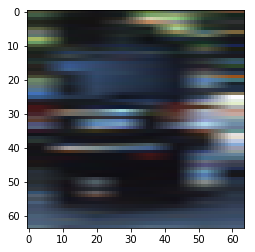

In [3]:
# just some random experiment
image = mpimg.imread('vehicles/KITTI_extracted/370.png')
plt.imshow(cv2.resize(cv2.resize(image, (8,64)), (64,64)), cmap='gray')

(1764,)


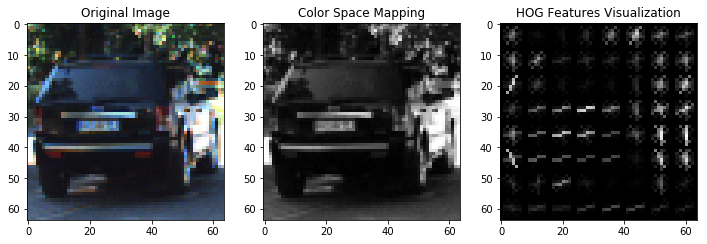

In [4]:
def extract_image_feature(img, debug=False):
    color_mapped = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if debug:
        features, hog_image = get_hog_features(color_mapped, 9, 8, 2, vis=True)
    else:
        features = get_hog_features(color_mapped, 9, 8, 2, vis=False)    
        
    if debug:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
        ax1.imshow(img)
        ax1.set_title('Original Image')
        ax2.imshow(color_mapped, cmap='gray')
        ax2.set_title('Color Space Mapping')
        ax3.imshow(hog_image, cmap='gray')
        ax3.set_title('HOG Features Visualization')
    
    return features
    

image = mpimg.imread('vehicles/KITTI_extracted/370.png')
features = extract_image_feature(image, True)
print (features.shape)

### 2. Build Classifier

In [5]:
def get_train_test_data():
    # import data and generate features X , labels y
    vehicle_paths = glob.glob('vehicles/*/*')#[0:100]
    nonvehicle_paths = glob.glob('non-vehicles/*/*')#[0:100]
    
    car_features = []
    notcar_features = []
    
    for path in tqdm(vehicle_paths,    desc='Extracting car image feature     '):
        car_features.append(extract_image_feature(mpimg.imread(path)))
    
    for path in tqdm(nonvehicle_paths, desc='Extracting non-car image feature '):
        notcar_features.append(extract_image_feature(mpimg.imread(path)))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    return train_test_split(scaled_X, y, test_size=0.2)


def train_model(X_train, X_test, y_train, y_test):
    print ('Training model ...')
    #model = LinearSVC(verbose=True)
    model = SVC(verbose=True)
    model.fit(X_train, y_train)
    print()
    print ('Model training done, calculating accuracy ...')
    accuracy = accuracy_score(model.predict(X_test), y_test)
    print ('Accuracy: ' + str(accuracy))
    return model

In [6]:
X_train, X_test, y_train, y_test = get_train_test_data()

Extracting non-car image feature : 100%|██████████| 8968/8968 [00:18<00:00, 480.07it/s]


In [7]:
model = train_model(X_train, X_test, y_train, y_test)

Training model ...
[LibSVM]Model training done, calculating accuracy ...
Accuracy: 0.991272522523


### 3. Sliding Window

### 4. Heat Map & Drawing

### 5. Video Output

In [16]:
frameLaneInfo = None

def processFrame(frame):
    return frame

In [21]:
clip = VideoFileClip('test_video.mp4').subclip(1,2)
frameLaneInfo = LaneInfo()
out_clip = clip.fl_image(processFrame)
%time out_clip.write_videofile('out.mp4', audio=False)
call(["say", "Video processing finished!"])

[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4


100%|██████████| 485/485 [02:32<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video.mp4 

CPU times: user 2min 20s, sys: 48.1 s, total: 3min 8s
Wall time: 2min 34s
